## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## Load all required libraries

In [86]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
from shapely.geometry.polygon import LinearRing, Polygon

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Pipeline parameters

In [87]:
# destination folder for out imgs
out_folder = 'output_images'
try: 
    os.mkdir(out_folder) 
except OSError as error: 
    print(error) 

# prepare object points
nx = 9
ny = 6

# calibration img data
calibration_path = 'camera_cal'
img_suffix = 'calibration'

# raw img
raw_path = 'test_images'

# kernel size for sobel algorithms
ksize = 15

# threshold for gradinet binary convertion
mod_thresh = (30, 100)
dir_thresh = (0.7, 1.3)

# threshold for color binary conversion
s_thresh = (170, 255)

# perspective transform parameter
lateral_pixel_offset = 150
upper_pixel_offset = 400
upper_pixel_length = 150

# Define conversions in x and y from pixels space to meters
MAX_LONG_LENGTH = 30
MAX_LAT_LENGTH = 3.7
PERP_TRANS_LONG_PIXELS = 720 # longitudinal result of perp transform
PERP_TRANS_LAT_PIXELS = 960 # is 1160-200 from perp trans parameters

# poly param
poly_degree = 2

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

[Errno 17] File exists: 'output_images'


## Support functions

In [88]:
def plot_imgs(img_list):
    fig=plt.figure(figsize=(24, 9))
    
    N_img = len(img_list)
    column = 3
    row = np.ceil(N_img/column)
    
    for idx, curr_img in enumerate(img_list):
        fig.add_subplot(row, column, idx+1)
        plt.imshow(curr_img)
        
    plt.show()
    fig.tight_layout()

def plot_calibration_result(img, undist_img, enable_saving=False):
    row = 1
    column = 2
    
    fig=plt.figure(figsize=(24, 9))
    fig.tight_layout()
    
    fig.add_subplot(row, column, 1)
    plt.imshow(img)
    plt.title('Original Image', fontsize=15)
    
    fig.add_subplot(row, column, 2)
    img_size = (undist_img.shape[1], undist_img.shape[0])
    plt.imshow(undist_img)
    plt.title('Undistorted Image', fontsize=15)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.1)
    if enable_saving:
        plt.savefig(out_folder + '/undistorted.png')
    plt.show()
    
def plot_binary_conversion(combined_grad_img, color_img, binary_img, enable_saving=False):
    row = 1
    column = 3
    
    fig=plt.figure(figsize=(24, 9))
    fig.tight_layout()
    
    fig.add_subplot(row, column, 1)
    plt.imshow(combined_grad_img, cmap='gray')
    plt.title('Gradient Image', fontsize=15)
    
    fig.add_subplot(row, column, 2)
    plt.imshow(color_img, cmap='gray')
    plt.title('Color Image', fontsize=15)
    
    fig.add_subplot(row, column, 3)
    plt.imshow(binary_img, cmap='gray')
    plt.title('Binary Image', fontsize=15)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.1)
    if enable_saving:
        plt.savefig(out_folder + '/binary_grad_color.png')
    plt.show()
    
def plot_lane_lines(perspec_img, histogram, lane_point_img, left_fitx, right_fitx, ploty, enable_saving=False):
    row = 1
    column = 3
    
    fig=plt.figure(figsize=(24, 9))
    fig.tight_layout()
    
    fig.add_subplot(row, column, 1)
    plt.imshow(perspec_img, cmap='gray')
    plt.title('perspec Image', fontsize=15)
    
    fig.add_subplot(row, column, 2)
    plt.plot(histogram)
    plt.title('Histogram Image', fontsize=15)
    
    fig.add_subplot(row, column, 3)
    plt.imshow(lane_point_img)
    plt.title('lane_point Image', fontsize=15)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.1)
    if enable_saving:
        plt.savefig(out_folder + '/perspective.png')
    plt.show()
    
def plot_persp_transf_boxes(binary_img, perspec_img, src_raw, dst_raw, enable_saving=False):
    row = 1
    column = 2
    
    fig=plt.figure(figsize=(24, 9))
    fig.tight_layout()
    
    fig.add_subplot(row, column, 1)
    plt.imshow(binary_img, cmap='gray')
    plt.title('Binary Image', fontsize=15)
    poly = Polygon(src_raw)
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#FF0000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
    fig.add_subplot(row, column, 2)
    plt.imshow(perspec_img, cmap='gray')
    plt.title('Perspec Image', fontsize=15)
    poly = Polygon(dst_raw)
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#FF0000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.1)
    if enable_saving:
        plt.savefig(out_folder + '/persp_transf_boxes.png')
    plt.show()
    
def draw_result(undist, warped, lane_point_img, Minv, left_fitx, right_fitx, ploty, curvature, ego_position, enable_saving=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    main_image = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    alpha = 0.5
    #overlay = np.zeros_like(undist).astype(np.uint8)
    overlay = undist.copy()
    
    # top overlay
    cv2.rectangle(overlay, (0, 0), (undist.shape[1], 250),(0, 0, 0), -1)
    # apply  overlay
    main_image = cv2.addWeighted(overlay, alpha, main_image, 1-alpha, 0)
    
    # Adding subplot
    binary_window = np.zeros_like(undist)
    binary_window  = cv2.resize(lane_point_img, (0,0), fx=0.3, fy=0.3)
    (height, width, _) = binary_window.shape  
    offset = 20    
    # main_image[offset:offset + height, main_image.shape[1] - width - offset:main_image.shape[1] - offset, :] = 0
    # main_image[offset:offset + height, main_image.shape[1] - width - offset:main_image.shape[1] - offset, :] = binary_window
    # main_image[offset:offset + height, main_image.shape[1] - width - offset:main_image.shape[1] - offset, :] = 0
    main_image[offset:offset + height, offset:offset + width, :] = binary_window
    
    # Write curvature and position text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_color = (250,0,0)
    line_type = 5
    
    text_size = 40
    text_displacement = round((height - 2*text_size)/3)
    
    radius_text_position = (2*offset + width, offset + text_displacement + text_size)
    center_text_position = (2*offset + width, offset + height - text_displacement)
    
    radius_text = "Curvature: {0:.2f} m".format(curvature)
    
    suffix = 'to the Right' if ego_position>=0 else 'to the Left'
        
    center_text = "Pos: {0:.2f}m".format(abs(ego_position)) 
    center_text += ' '+suffix

    cv2.putText(main_image, radius_text,  radius_text_position, font, font_scale, font_color, line_type)
    cv2.putText(main_image, center_text,  center_text_position, font, font_scale, font_color, line_type)
    
    if enable_saving:
        cv2.imwrite(out_folder + '/main_image.png', cv2.cvtColor(main_image, cv2.COLOR_RGB2BGR))
    
    return main_image
    

## Compute the camera calibration matrix and distortion coefficients

In [89]:
def compute_calibration_coefficients(path, img_suffix, nx, ny):
    # prepare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Join various path components  
    img_path = os.path.join(path, img_suffix)
    
    # Make a list of calibration images
    images = glob.glob(img_path + "*.jpg")
    
    if len(images) < 1:
        return [-1, 0, 0, 0, 0];
    
    # Step through the list and search for chessboard corners
    fig=plt.figure(figsize=(24, 100))
    row = len(images)
    column = 3
    img_saved = False
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        fig.add_subplot(row, column, column*idx + 1)
        plt.imshow(img)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        fig.add_subplot(row, column, column*idx + 2)
        plt.imshow(gray, cmap='gray')

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Save corners
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            fig.add_subplot(row, column, column*idx + 3)
            plt.imshow(img)
            if not img_saved:
                img_saved = True
                plt.savefig(out_folder + '/calibration.png')
        else:
            print("WARNING: no corner found in ", fname)
    plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


## Compute calibration coefficients

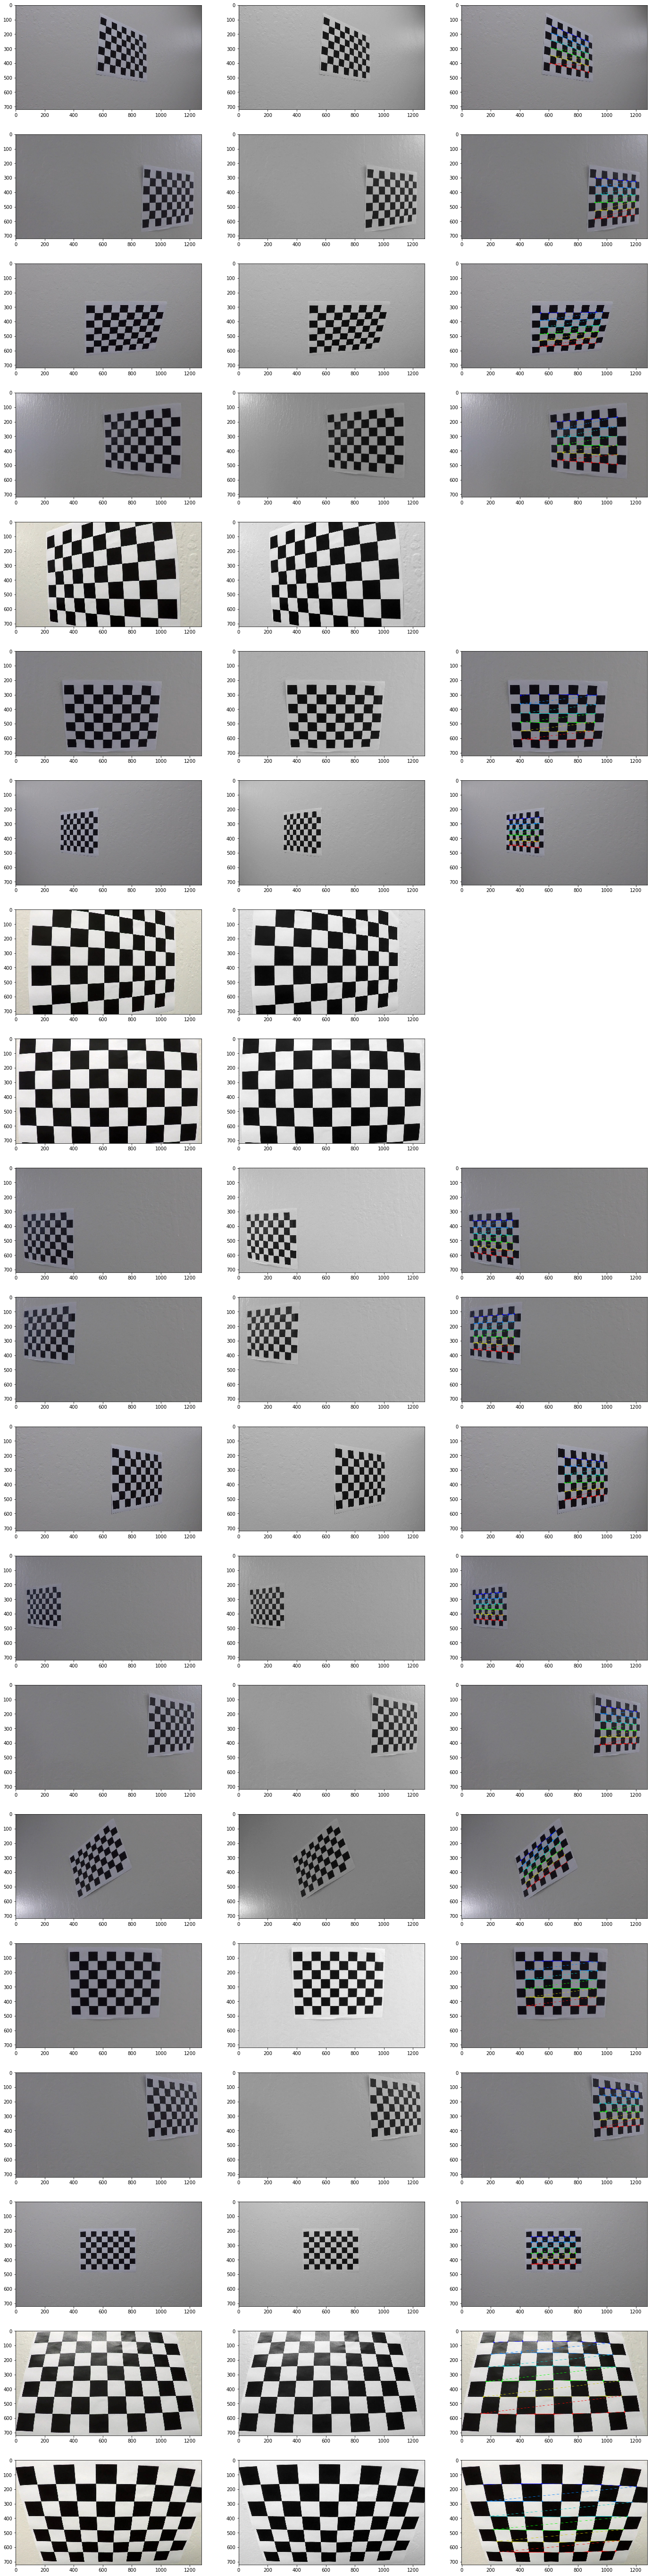

In [90]:
# compute the calibration matrix and distortion parameters
ret, mtx, dist, rvecs, tvecs = compute_calibration_coefficients(calibration_path, img_suffix, nx, ny)

## Correcting for camera distorition

In [91]:
def undistorted_image(raw_img, mtx, dist):
    # curr_undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    
    h,  w = raw_img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

    # undistort
    dst = cv2.undistort(raw_img, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    curr_undist = dst[y:y+h, x:x+w]
    
    return curr_undist


## Transform perspective

In [92]:
def perspective_transform(img):
    # compute the perspective transform vectors
    img_size = (img.shape[1], img.shape[0])
    
    src_raw = [[(img_size[0]+upper_pixel_length)*.5, upper_pixel_offset],
               [img_size[0]-lateral_pixel_offset, img_size[1]], 
               [lateral_pixel_offset, img_size[1]], 
               [(img_size[0]-upper_pixel_length)*.5, upper_pixel_offset]]
    
    dst_raw = [[img_size[0]-lateral_pixel_offset, 0],
               [img_size[0]-lateral_pixel_offset, img_size[1]], 
               [lateral_pixel_offset, img_size[1]], 
               [lateral_pixel_offset, 0]]

    src_points = np.float32(src_raw)
    dst_points = np.float32(dst_raw)
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    # Warp the image using the perspective transform
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv, src_raw, dst_raw

## Gradient analysis function

In [93]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if 'x' == orient:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif 'y' == orient:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Input orientation not valid. Please specify x or y")
        exit()
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobel = np.sqrt((sobelx*sobelx) + (sobely*sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # grayscale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # sobel algorithm
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # compute gradient direction
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    grd_dir = np.arctan2(abs_y, abs_x)
    # binary_output = np.uint8(255*grd_dir/np.max(grd_dir))
    binary_output = np.zeros_like(grd_dir)
    binary_output[(grd_dir >= thresh[0]) & (grd_dir <= thresh[1])] = 1
    return binary_output

def combine_gradients(img, ksize, mod_thresh, dir_thresh):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=mod_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=mod_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=mod_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

## Color transformation

In [94]:
def color_transformation(img, s_thresh):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
    
def combine_gradinet_with_color(grad_img, color_img):
    # combine the contribution of the two channel
    combined_binary = np.zeros_like(grad_img)
    combined_binary[(color_img == 1) | (grad_img == 1)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(grad_img), grad_img, color_img)) * 255
    
    return [combined_binary, color_binary]


## Find lane poly 

In [95]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # plot the lane sample 
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img, histogram

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, poly_degree)
    right_fit = np.polyfit(righty, rightx, poly_degree)
    
    ## Visualization ##
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, plot_enabled=False):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values 
    left_poly = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = (nonzerox > (left_poly - margin)) & (nonzerox < (left_poly + margin))
    right_poly = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = (nonzerox > (right_poly - margin)) & (nonzerox < (right_poly + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    lane_point_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    if plot_enabled:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##   
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram, lane_point_img, left_fitx, right_fitx, ploty

def step_find_lane_lines(perspec_img):
    leftx, lefty, rightx, righty, out_img, histogram = find_lane_pixels(perspec_img)
    
    left_fitx, right_fitx, ploty = fit_poly(perspec_img.shape, leftx, lefty, rightx, righty)
    
    return histogram, out_img, left_fitx, right_fitx, ploty

## Compute curvature

In [96]:
def measure_curvature_pixels(left_fitx, right_fitx, ploty):
    # compute fit parameters
    left_fit = np.polyfit(ploty, left_fitx, poly_degree)
    right_fit = np.polyfit(ploty, right_fitx, poly_degree)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = np.power(1 + np.power(2*left_fit[0]*y_eval + left_fit[1], 2), 3/2) / np.absolute(2*left_fit[0])
    right_curverad = np.power(1 + np.power(2*right_fit[0]*y_eval + right_fit[1], 2), 3/2) / np.absolute(2*right_fit[0])
    
    mean_curverad = (left_curverad + right_curverad)*.5
    
    return mean_curverad

def measure_curvature_meters(left_fitx, right_fitx, ploty):
    # conversion parameters
    ym_per_pix = MAX_LONG_LENGTH/PERP_TRANS_LONG_PIXELS # meters per pixel in y dimension
    xm_per_pix = MAX_LAT_LENGTH/(right_fitx[-1] - left_fitx[-1]) # meters per pixel in x dimension
    
    # compute fit parameters
    left_fit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, poly_degree)
    right_fit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, poly_degree)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = np.power(1 + np.power(2*left_fit[0]*y_eval + left_fit[1], 2), 3/2) / np.absolute(2*left_fit[0])
    right_curverad = np.power(1 + np.power(2*right_fit[0]*y_eval + right_fit[1], 2), 3/2) / np.absolute(2*right_fit[0])
    
    mean_curverad = (left_curverad + right_curverad)*.5
    
    return mean_curverad

## Determine ego position

In [97]:
def determine_ego_position(img, left_fitx, right_fitx):
    # conversion parameters
    ym_per_pix = MAX_LONG_LENGTH/PERP_TRANS_LONG_PIXELS # meters per pixel in y dimension
    xm_per_pix = MAX_LAT_LENGTH/(right_fitx[-1] - left_fitx[-1]) # meters per pixel in x dimension
    
    diff = (img.shape[1]/2) - ((left_fitx[-1] + right_fitx[-1]) /2)
    return diff*xm_per_pix

## Pipeline

In [98]:
def advenced_lane_finding_pipeline(img, enable_plot=False):
    # remove distortion from image
    undist_img = undistorted_image(img, mtx, dist)
    
    # compute combined gradient binary
    combined_grad_img = combine_gradients(undist_img, ksize, mod_thresh, dir_thresh)
    
    # compute color binary
    color_img = color_transformation(undist_img, s_thresh)
    
    # combine the two contributions
    binary_img, stack_img = combine_gradinet_with_color(combined_grad_img, color_img)
    
    # perspective transform
    perspec_img, M, Minv, src_raw, dst_raw = perspective_transform(binary_img)
    
    # find lane points
    histogram, lane_point_img, left_fitx, right_fitx, ploty = step_find_lane_lines(perspec_img)
    
    # compute curvature
    curvature = measure_curvature_meters(left_fitx, right_fitx, ploty)
    
    # compute ego position
    ego_pos = determine_ego_position(img, left_fitx, right_fitx)
    
    # compose the final image
    fin_img = draw_result(undist_img, perspec_img, lane_point_img, Minv, left_fitx, right_fitx, ploty, curvature, ego_pos, True)
    
    # plots
    if enable_plot:
        print("CALIBRATION RESULTS")
        plot_calibration_result(img, undist_img, True)

        print("BINARY CONVERSION (GRADIENTS + COLOR TRANSFORMATIONS)")
        plot_binary_conversion(combined_grad_img, color_img, binary_img, True)
        
        print("PERSPECTIVE TRANSFORMATION BOXES")
        plot_persp_transf_boxes(combined_grad_img, perspec_img, src_raw, dst_raw, True)
    
        print("FOUND LANE LINES")
        plot_lane_lines(perspec_img, histogram, lane_point_img, left_fitx, right_fitx, ploty, True)
        
        
    return fin_img

## Test pipeline

CALIBRATION RESULTS


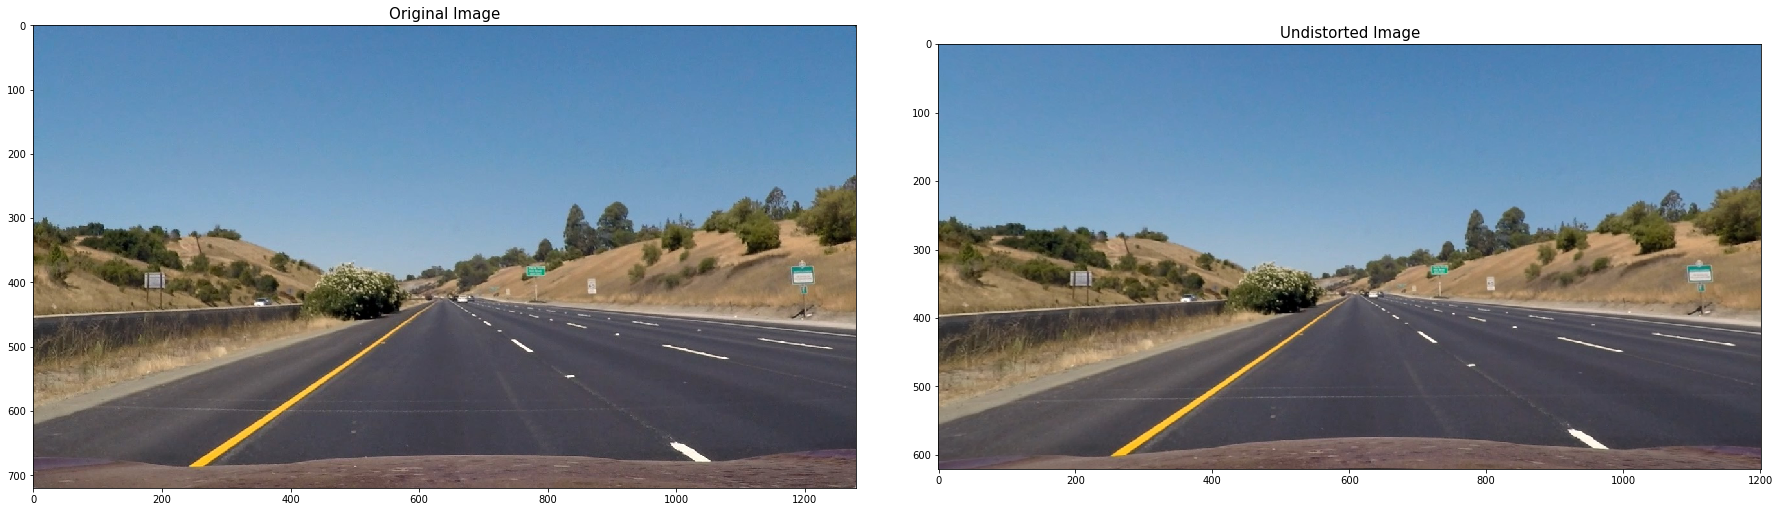

BINARY CONVERSION (GRADIENTS + COLOR TRANSFORMATIONS)


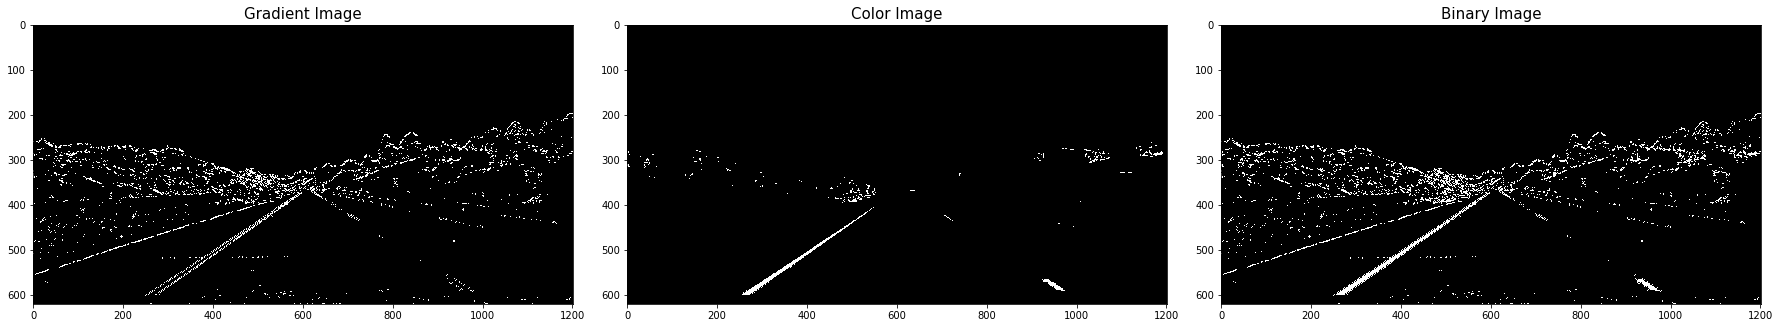

FOUND LANE LINES


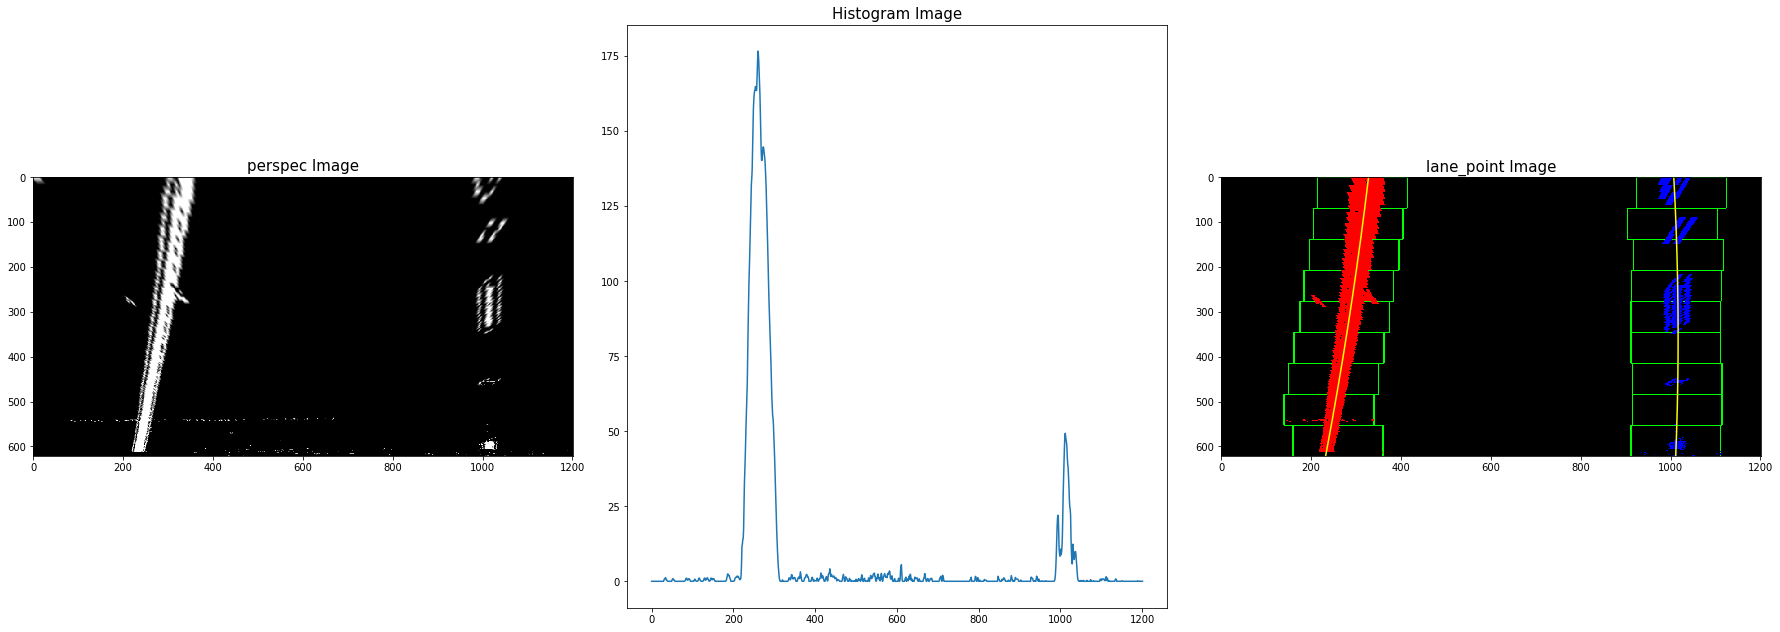

PERSPECTIVE TRANSFORMATION BOXES


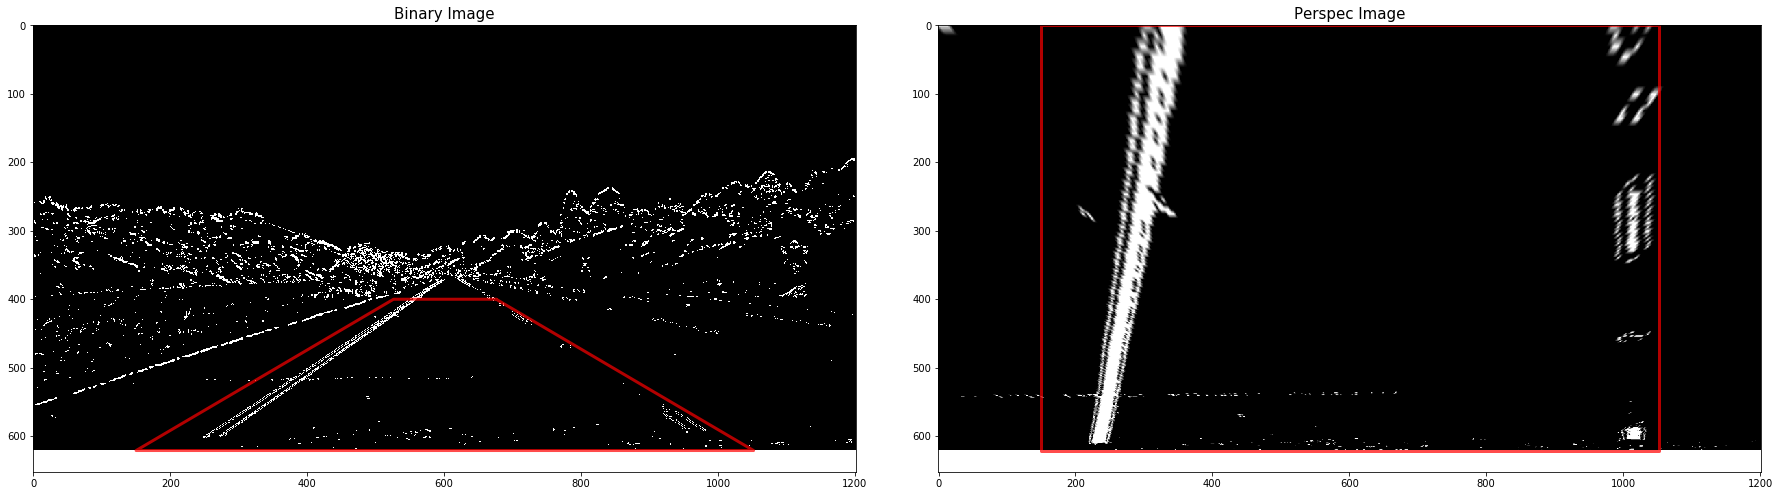

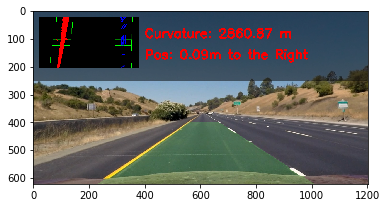

In [99]:
# test pipeline using test_images content
# Make a list of calibration images
images = glob.glob(os.path.join(raw_path, "*.jpg"))

if len(images) < 1:
    print("ERROR: no jpg file found in ", path)
    exit();

# Step through the list and search for chessboard corners
for fname in images:
    raw_img = mpimg.imread(fname)
    curr_img = advenced_lane_finding_pipeline(raw_img, True)
    plt.imshow(curr_img)
    break

## Test video

In [100]:
def process_current_frame_pip(img, enable_plot=False):
    global first_exec
    global prev_left_fit
    global prev_right_fit
    
    # remove distortion from image
    undist_img = undistorted_image(img, mtx, dist)

    # compute combined gradient binary
    combined_grad_img = combine_gradients(undist_img, ksize, mod_thresh, dir_thresh)

    # compute color binary
    color_img = color_transformation(undist_img, s_thresh)

    # combine the two contributions
    binary_img, stack_img = combine_gradinet_with_color(combined_grad_img, color_img)

    # perspective transform
    perspec_img, M, Minv, src_raw, dst_raw = perspective_transform(binary_img)

    # find lane points
    if first_exec:
        histogram, lane_point_img, left_fitx, right_fitx, ploty = step_find_lane_lines(perspec_img)
        first_exec = False
    else:
        histogram, lane_point_img, left_fitx, right_fitx, ploty = search_around_poly(perspec_img, prev_left_fit, prev_right_fit)
    
    # update prev fit variables
    prev_left_fit = np.polyfit(ploty, left_fitx, poly_degree)
    prev_right_fit = np.polyfit(ploty, right_fitx, poly_degree)
    
    # compute curvature
    curvature = measure_curvature_meters(left_fitx, right_fitx, ploty)

    # compute ego position
    ego_pos = determine_ego_position(img, left_fitx, right_fitx)

    # compose the final image
    fin_img = draw_result(undist_img, perspec_img, lane_point_img, Minv, left_fitx, right_fitx, ploty, curvature, ego_pos)

    # plots
    if enable_plot:
        print("CALIBRATION RESULTS")
        plot_calibration_result(img, undist_img)

        print("BINARY CONVERSION (GRADIENTS + COLOR TRANSFORMATIONS)")
        plot_binary_conversion(combined_grad_img, color_img, binary_img)

        print("FOUND LANE LINES")
        plot_lane_lines(perspec_img, histogram, lane_point_img, left_fitx, right_fitx, ploty)

    return fin_img

def process_image(img):
    return process_current_frame_pip(img)


In [101]:
first_exec = True
prev_left_fit = 0
prev_right_fit = 0
file_name = 'project_video.mp4'
white_output = 'output_videos/' + file_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [07:09<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 51s, sys: 1.36 s, total: 4min 52s
Wall time: 7min 12s


## Challenge video

In [102]:
first_exec = True
prev_left_fit = 0
prev_right_fit = 0
file_name = 'challenge_video.mp4'
white_output = 'output_videos/' + file_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [02:41<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 51s, sys: 617 ms, total: 1min 51s
Wall time: 2min 44s


## Harder challenge video

In [103]:
file_name = 'harder_challenge_video.mp4'
white_output = 'output_videos/' + file_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [07:57<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 4min 57s, sys: 1.13 s, total: 4min 58s
Wall time: 8min 2s
